### Importing the basic dependencies

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Reading in the test image as gray scale

In [42]:
img = cv2.imread('chuyengia.png')

In [43]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

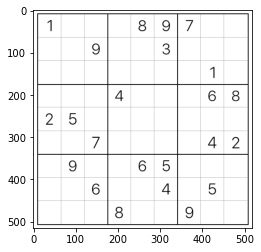

In [44]:
plt.imshow(gray,cmap='gray')

In [45]:
gray.shape

(515, 518)

### Applying Gaussian Blurring to reduce Background Noise

In [46]:
dst = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT)

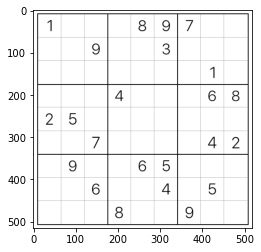

In [47]:
plt.imshow(dst,cmap='gray')

### Applying Inverse Binary Threshold

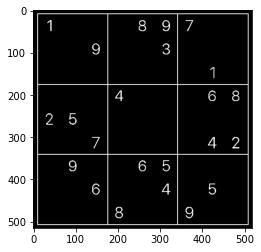

In [48]:
ret,thresh_inv = cv2.threshold(gray, 180, 255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh_inv,cmap='gray')

### Applying Probabilistic Hough Transform on the Binary Image

In [49]:
minLineLength = 100
maxLineGap = 60
lines = cv2.HoughLinesP(thresh_inv,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for l in lines:
    x1,y1,x2,y2 = l[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2, cv2.LINE_AA)
cv2.imwrite('hough.jpg',img)

True

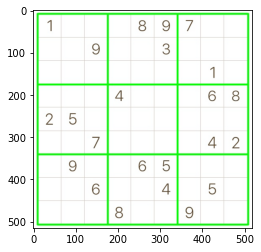

In [50]:
img_hough = cv2.imread('hough.jpg',0)
img_show = cv2.imread('hough.jpg')
plt.imshow(img_show, cmap='gray')

### Finding Contours

In [51]:
contours,hierarchy = cv2.findContours(img_hough,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [52]:
# find the biggest area
cnt = contours[0]
max_area = cv2.contourArea(cnt)

for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)

In [53]:
max_area

265738.0

### Replacing the contour by it's approximate encompassing polygon

In [54]:
epsilon = 0.01*cv2.arcLength(cnt,True)
poly_approx = cv2.approxPolyDP(cnt, epsilon, True)

In [55]:
poly_approx

array([[[  0,   0]],

       [[  0, 514]],

       [[517, 514]],

       [[517,   0]]], dtype=int32)

### Applying Perspective Transform on the edge detected image with the Poly_Approx points

In [56]:
#function that takes in points
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[3]
    rect[1] = pts[1]

    # return the ordered coordinates
    return rect

In [57]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [0, maxHeight - 1],
        [maxWidth - 1, maxHeight - 1],
        [maxWidth - 1, 0]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [58]:
img_PT = four_point_transform(thresh_inv,poly_approx)

In [59]:
img_PT.shape

(517, 514)

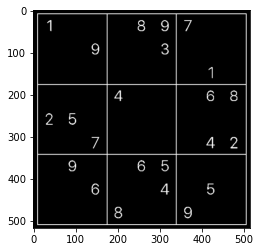

In [60]:
plt.imshow(img_PT, cmap='gray')

In [61]:
cv2.imwrite('img_PT.jpg',img)

True

### Neural Network Model trained to recognize digits

In [62]:
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from tensorflow.keras.layers import Dense, Dropout, Flatten # core layers

from keras.layers.normalization import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

from keras.datasets import mnist

In [63]:
# (X_train,y_train),(X_test,y_test)=mnist.load_data()
# plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
# plt.show()

In [64]:
# X_train = X_train.reshape(60000, 28, 28, 1)
# X_test = X_test.reshape(10000, 28, 28, 1)

In [65]:
# X_train=X_train/255
# X_test = X_test / 255

In [66]:
# from keras.utils import np_utils
# y_train=np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)
# num_classes=y_test.shape[1]

In [67]:
# ## Declare the model
# model = Sequential()

# ## Declare the layers
# layer_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1))
# layer_2 = Conv2D(64, kernel_size=3, activation='relu')
# layer_3 = Flatten()
# layer_4 = Dense(10, activation='softmax')

# ## Add the layers to the model
# model.add(layer_1)
# model.add(layer_2)
# model.add(layer_3)
# model.add(layer_4)

In [68]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

In [70]:
# model.save('keras_digit_model.h5')

### Predicting on new test image

(700, 700)

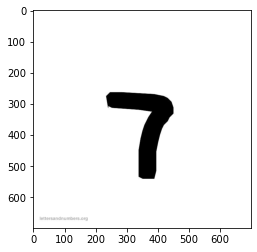

In [71]:
test_image = cv2.imread('7.jpg',0) #reading in grayscale
plt.imshow(test_image,cmap='gray')
test_image.shape

In [72]:
from tensorflow.keras.models import load_model
new_model = load_model('keras_digit_model.h5')

In [73]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

ret, thresh = cv2.threshold(test_image.copy(), 75, 255, cv2.THRESH_BINARY_INV)
resized_digit = cv2.resize(thresh, (28,28))
resized_digit = resized_digit.reshape(1,28,28,1)
resized_digit = tf.cast(resized_digit, tf.float32) #for linux (tf2.0)
prediction = new_model.predict(resized_digit)
prediction

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [74]:
def prediction(test_image):
    
    classes = new_model.predict_classes(test_image)
    
    if classes == [[0]]:
        return 0
    elif classes == [[1]]:
        return 1
    elif classes == [[2]]:
        return 2
    elif classes == [[3]]:
        return 3
    elif classes == [[4]]:
        return 4
    elif classes == [[5]]:
        return 5
    elif classes == [[6]]:
        return 6
    elif classes == [[7]]:
        return 7
    elif classes == [[8]]:
        return 8
    elif classes == [[9]]:
        return 9

In [75]:
prediction(resized_digit)

5

### Finding and extracting the sudoku digits

In [76]:
import tensorflow as tf
from PIL import Image

In [77]:
#creating a function to get the different position of cells
def getCellPositions(img_PT):
    #resizing the images to take the shape of the NN model
    img_PT = cv2.resize(img,(252,252))
    #computing position of each cell and storing in an array of arrays
    cell_positions = []
    
    width = img_PT.shape[1]
    height = img_PT.shape[0]
    
    cell_width = width//9
    cell_height = height//9
    
    x1,x2,y1,y2 = 0,0,0,0
    
    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions   

In [78]:
#using the trained model to predict the digits in each cell, if cell is empty fix with 0
def predictDigit(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:
        result = 0
    if pos:
        img1 = img[(pos[0][1]):(pos[0][3]),(pos[0][0]):(pos[0][2])]
        #img1 = img[4:25,5:23]
        #22-3-2020
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        img1 = tf.cast(img1, tf.float32) #for linux (tf2.0)

        result = prediction(img1)
        
    return result

In [79]:
def extractSudokuDigits(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    cell_digits,num = [],0
    cells = getCellPositions(img_PT)
    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_PT)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

In [80]:
#testing the extraction process for one sudoku picture
a = extractSudokuDigits(img_PT)
a

[[3, 0, 0, 0, 2, 6, 7, 0, 0],
 [0, 0, 6, 0, 0, 5, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 8, 0],
 [0, 0, 0, 1, 0, 0, 0, 8, 8],
 [2, 8, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 0, 0, 0, 0, 3],
 [0, 8, 0, 0, 6, 5, 0, 0, 0],
 [0, 0, 5, 0, 0, 4, 0, 0, 0],
 [0, 0, 0, 3, 0, 0, 0, 0, 0]]

### Solving Sudoku Puzzle with Backtracking

In [33]:
def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")
                
#displaying our sudoku board in its array format (digit 0 represents empty cells)             
print_board(a)

3 0 0  | 0 3 6  | 9 0 0
0 0 6  | 0 0 3  | 0 0 0
0 0 0  | 0 0 0  | 0 8 0
- - - - - - - - - - - - - 
0 0 0  | 1 0 0  | 0 8 8
2 5 0  | 0 0 0  | 0 0 0
0 0 2  | 0 0 0  | 0 4 0
- - - - - - - - - - - - - 
0 8 0  | 0 6 7  | 0 0 0
0 0 5  | 0 0 4  | 0 0 0
0 0 0  | 3 0 0  | 0 0 0


In [34]:
#helper function to get the empty cells
def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)
    return None

In [35]:
#helper function to validate placement of new digits in empty cells
def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

In [36]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False

In [ ]:
#using the function to solve digits extracted from the image
print_board(a)
print('\n')
solve(a)
print_board(a)

3 0 0  | 0 3 6  | 9 0 0
0 0 6  | 0 0 3  | 0 0 0
0 0 0  | 0 0 0  | 0 8 0
- - - - - - - - - - - - - 
0 0 0  | 1 0 0  | 0 8 8
2 5 0  | 0 0 0  | 0 0 0
0 0 2  | 0 0 0  | 0 4 0
- - - - - - - - - - - - - 
0 8 0  | 0 6 7  | 0 0 0
0 0 5  | 0 0 4  | 0 0 0
0 0 0  | 3 0 0  | 0 0 0




### Putting back the digits on the picture

In [ ]:
#looking for the empty cells and returning
def detectEmptyCell(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:    
        return pos
    else:
        return 0

In [ ]:
#placing the valid digits for the puzzle in the empty cells and visualizing
def placeSudokuDigits(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    img_PT = cv2.resize(img_PT,(252,252)) #had to reshape the image size to fit the model shape
    img_color = cv2.resize(img,(252,252))
    cells = getCellPositions(img_PT)
    n = 9
    cr = [cells[i:i+n] for i in range(0, len(cells), n)] #cr meaning cells reshaped
    digits = extractSudokuDigits(img_PT)
    solve(digits) 
    for i in range(len(cr)):
        for j in range(len(cr[i])):
            pos = detectEmptyCell(cr[i][j],img_PT)
            digit_text = digits[i][j]
            if pos == []:
                cv2.putText(img_color, str(digit_text), ((cr[i][j][0]+8),(cr[i][j][2]+19)),cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                continue  
    plt.imshow(img_color,cmap='gray')

In [ ]:
placeSudokuDigits(img_PT)

### Helper function for solving the Puzzle via Webcam

In [ ]:
def placeSudokuDigitsLive(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    img_PT = cv2.resize(img_PT,(252,252)) #had to reshape the image size to fit the model shape
    img_color = cv2.resize(frame,(252,252)) #img is got from the grayscale
    cells = getCellPositions(img_PT)
    n = 9
    cr = [cells[i:i+n] for i in range(0, len(cells), n)] #cr meaning cells reshaped
    digits = extractSudokuDigits(img_PT)
    solve(digits) 
    for i in range(len(cr)):
        for j in range(len(cr[i])):
            pos = detectEmptyCell(cr[i][j],img_PT)
            digit_text = digits[i][j]
            if pos == []:
                cv2.putText(img_color, str(digit_text), ((cr[i][j][0]+8),(cr[i][j][2]+19)),cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                continue  
    

### Reading in live video of the Sudoku Puzzle via Webcam

In [ ]:
# PUTTING THIS ALL IN ONE CELL!

import cv2

# Connects to your computer's default camera
cap = cv2.VideoCapture(0)

# Automatically grab width and height from video feed
# (returns float which we need to convert to integer for later on!)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#to run some lines once
flag = True

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    #Convert the captured frame into grayscale
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    
    #This segment of the code works on the board segment of the frame
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    # find the biggest area
    cnt = contours[0]
    max_area = cv2.contourArea(cnt)

    for cont in contours:
        if cv2.contourArea(cont) > max_area:
            cnt = cont
            max_area = cv2.contourArea(cont)
    epsilon = 0.01*cv2.arcLength(cnt,True)
    poly_approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    board_segment = four_point_transform(gray,poly_approx)

    #Applying Gaussian Blurring to the image
    dst = cv2.GaussianBlur(board_segment,(1,1),cv2.BORDER_DEFAULT)
    
    #Applying Inverse Binary Threshold to the image
    ret,thresh_inv = cv2.threshold(dst, 180, 255,cv2.THRESH_BINARY_INV)
    
    #Applying Probabilistic Hough Transform on the Binary Image
    minLineLength = 100
    maxLineGap = 60
    lines = cv2.HoughLinesP(thresh_inv,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
    for l in lines:
        x1,y1,x2,y2 = l[0]
        cv2.line(board_segment,(x1,y1),(x2,y2),(0,255,0),2, cv2.LINE_AA)
        
    if flag:
        #using neural network model to detect the digits in the image
        #new_model = load_model('keras_digit_model.h5')
        a = extractSudokuDigits(thresh_inv)

        #solving with backtracking
        solve(a)

        #putting back the solved digits on spaces that are empty
        placeSudokuDigitsLive(thresh_inv) #this function won't have the plt.imshow() and also, 
                                    #the colored image would be img
        
        flag = False
        
    #overlaying the board segment of the image on the frame
    x_offset, y_offset = (poly_approx[0][0].tolist()[0]),(poly_approx[0][0].tolist()[1])
    x_end, y_end = (x_offset+board_segment.shape[1]), (y_offset+board_segment.shape[0])
    frame[y_offset:y_end,x_offset:x_end] = board_segment
        
    # Display the resulting frame
    cv2.imshow('frame',frame)
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't work!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()